# TP : Proximal coordinate descent method on regression models

#### Authors: R. Gower, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 16 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "xiangnan"
ln1 = "yue"
fn2 = "junfeng"
ln2 = "chen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_yue_xiangnan_and_chen_junfeng.ipynb


In [3]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

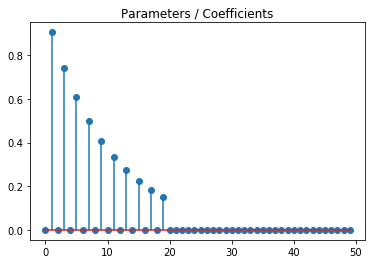

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [6]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

In [7]:
toeplitz(0.1**np.arange(0,n_features))

array([[  1.00e+00,   1.00e-01,   1.00e-02, ...,   1.00e-47,   1.00e-48,
          1.00e-49],
       [  1.00e-01,   1.00e+00,   1.00e-01, ...,   1.00e-46,   1.00e-47,
          1.00e-48],
       [  1.00e-02,   1.00e-01,   1.00e+00, ...,   1.00e-45,   1.00e-46,
          1.00e-47],
       ..., 
       [  1.00e-47,   1.00e-46,   1.00e-45, ...,   1.00e+00,   1.00e-01,
          1.00e-02],
       [  1.00e-48,   1.00e-47,   1.00e-46, ...,   1.00e-01,   1.00e+00,
          1.00e-01],
       [  1.00e-49,   1.00e-48,   1.00e-47, ...,   1.00e-02,   1.00e-01,
          1.00e+00]])

In [8]:
multivariate_normal?

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

## code a function that computes g and prox_g

In [9]:
def prox_lasso(y, s, t=1.):
    """Proximal operator for the Lasso at y with strength t"""    
    return np.sign(y)*np.maximum(np.abs(y)-s*t, 0) # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.linalg.norm(x,ord=1) # TODO

def prox_indic(y, s, t=1.):
    """Proximal operator for the indicator function at y with strength t"""    
    return np.maximum(0, y) # TODO
    
def indic(x, s):
    """Value of the indicator penalization at x with strength t"""
    return 0 if np.all(x>=0) else np.inf # TODO

In [10]:
x = np.array([2,3,4,-1])
np.all(x>0)

np.maximum(0, x)

array([2, 3, 4, 0])

## Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions

here we know that $ \frac{1}{2} \|b - Ax\|^2 $
and $ g(x) = i_{x \in \mathbb{R}_+^n}(\cdot) $ are both convex function.
Moreover, the $ \frac{1}{2} \|b - Ax\|^2 $ has Lipschitz-continuous gradient and $ g(x) = i_{x \in \mathbb{R}_+^n}(\cdot) $ is separable.


## Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties

In [11]:

def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(n_iter + 1):

        #### TODO ####
        for i in range(n_features):
            df_i = np.dot(A[:, i].T, -b + np.dot(A, x))
            y_i = x[i] - s*df_i
            x_new[i] = prox_g(y_i, s)
            
        # update x_old
        x = x_new
        
        ##### END ########
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
# prepare the params
x0 = np.zeros(n_features)
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
g = lasso
prox_g = prox_lasso

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    # n = np.size(A,axis=0)
    return np.linalg.svd(a=A)[1][0]**2

s = 1/lip_linreg(A)

In [13]:
final_x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)

Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.16e+03 | 6.84e-01
      10 | 4.81e+02 | 1.91e-01
      20 | 4.81e+02 | 1.96e-01
      30 | 4.81e+02 | 1.97e-01
      40 | 4.81e+02 | 1.97e-01
      50 | 4.81e+02 | 1.97e-01


In [14]:
g = indic
prox_g = prox_indic
final_x_indic, objectives_indic, errors_indic = cd_linreg(x0, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)

Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.14e+03 | 6.77e-01
      10 | 4.93e+02 | 1.45e-01
      20 | 4.93e+02 | 1.42e-01
      30 | 4.93e+02 | 1.42e-01
      40 | 4.93e+02 | 1.42e-01
      50 | 4.93e+02 | 1.42e-01


## Evaluate qualitatively the convergence when varying the conditioning of the problem.

### original parametres

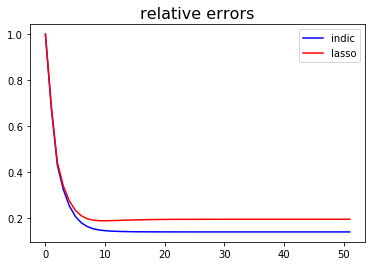

In [15]:
plt.plot(errors_indic, "b", label="indic")
plt.plot(errors, "r", label="lasso")
plt.legend()
plt.title("relative errors", fontsize=16)

### change the correlation parametres for the covariance matrix 

Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.39e+03 | 6.67e-01
      10 | 4.77e+02 | 1.68e-01
      20 | 4.77e+02 | 1.69e-01
      30 | 4.77e+02 | 1.69e-01
      40 | 4.77e+02 | 1.69e-01
      50 | 4.77e+02 | 1.69e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.86e+03 | 8.37e-01
      10 | 4.65e+02 | 1.58e-01
      20 | 4.65e+02 | 1.59e-01
      30 | 4.65e+02 | 1.59e-01
      40 | 4.65e+02 | 1.59e-01
      50 | 4.65e+02 | 1.59e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.22e+03 | 8.92e-01
      10 | 4.72e+02 | 2.86e-01
      20 | 4.69e+02 | 2.40e-01
      30 | 4.69e+02 | 2.33e-01
      40 | 4.69e+02 | 2.32e-01
      50 | 4.69e+02 | 2.32e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.17e+03 | 8.40e-01
      10 | 4.90e+02 | 3.94e-01
      20 | 4.72e+02 | 3.00e-01
      30 | 4.67e+02 | 2.78e-01
      40 | 4.66e+02 | 2.76e-01
      5

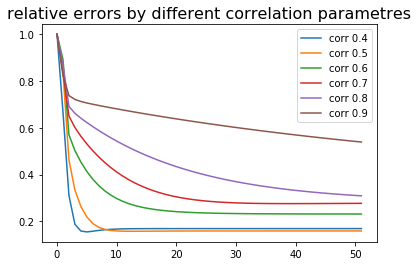

In [16]:
# prepare the params

g = lasso
prox_g = prox_lasso

for i in range(4,10):
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.1*i)
    s = 1/lip_linreg(A)
    x0 = np.zeros(n_features)
    final_x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)
    
    plt.plot(errors, label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("relative errors by different correlation parametres", fontsize=16)

- with smaller corr, the covariance matrix is approaching unit matrix, the singular value is larger and thus convergence speed is quicker.

### change the start vector x0

Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 5.98e+03 | 1.87e+00
      10 | 4.70e+02 | 1.58e-01
      20 | 4.70e+02 | 1.58e-01
      30 | 4.70e+02 | 1.58e-01
      40 | 4.70e+02 | 1.58e-01
      50 | 4.70e+02 | 1.58e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.30e+03 | 6.56e-01
      10 | 4.70e+02 | 1.58e-01
      20 | 4.70e+02 | 1.58e-01
      30 | 4.70e+02 | 1.58e-01
      40 | 4.70e+02 | 1.58e-01
      50 | 4.70e+02 | 1.58e-01


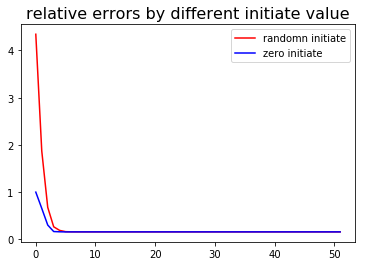

In [17]:
g = lasso
prox_g = prox_lasso
A,b = simu_linreg(coefs, n_samples=1000, corr = 0.3)
s = 1/lip_linreg(A)

xr0 = np.random.randn(n_features)
final_xr, objectivesr, errorsr = cd_linreg(xr0, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)
x00 = np.zeros(n_features)
final_x, objectives, errors = cd_linreg(x00, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)

plt.plot(errorsr,"r", label="randomn initiate") 
plt.plot(errors,"b", label="zero initiate") 
plt.legend()
plt.title("relative errors by different initiate value", fontsize=16)

- zero initiate gets better results for starting errors.

### change the value of s

Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.47e+03 | 7.41e-01
      10 | 4.65e+02 | 1.57e-01
      20 | 4.65e+02 | 1.56e-01
      30 | 4.65e+02 | 1.56e-01
      40 | 4.65e+02 | 1.56e-01
      50 | 4.65e+02 | 1.56e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 6.86e+02 | 6.22e-01
      10 | 4.69e+02 | 1.86e-01
      20 | 4.65e+02 | 1.59e-01
      30 | 4.65e+02 | 1.56e-01
      40 | 4.65e+02 | 1.56e-01
      50 | 4.65e+02 | 1.56e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.11e+03 | 7.73e-01
      10 | 5.01e+02 | 3.17e-01
      20 | 4.71e+02 | 2.03e-01
      30 | 4.66e+02 | 1.70e-01
      40 | 4.65e+02 | 1.61e-01
      50 | 4.65e+02 | 1.58e-01
Launching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.52e+03 | 8.80e-01
      10 | 5.75e+02 | 4.74e-01
      20 | 5.07e+02 | 3.37e-01
      30 | 4.84e+02 | 2.58e-01
      40 | 4.73e+02 | 2.12e-01
      5

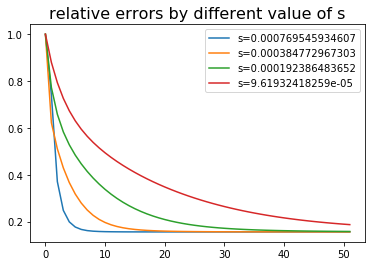

In [18]:
g = lasso
prox_g = prox_lasso
A,b = simu_linreg(coefs, n_samples=1000, corr = 0.4)
#s = 1e-3
#s = 1/lip_linreg(A)

for i in range(1,5):
    s = 1/(np.linalg.svd(a=A)[1][0]**2/4)*(0.5**i)
    x0 = np.zeros(n_features)
    final_x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s, n_iter=50, x_true=coefs, verbose=True)
    
    plt.plot(errors, label="s=%s" % (s)) 
    plt.legend()
    plt.title("relative errors by different value of s", fontsize=16)



- with a larger s the speed of convergence is quicker, yet s cannot be too large to break the convergence condition